In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
from pprint import pprint

BATCH_SIZE = 2
IMAGE_SIZE = (256, 384)
BBOX_FORMAT = "xywh"

class_map = {
    0: "box",
    1: "green_light",
    2: "left_arrow",
    3: "no_light",
    4: "person",
    5: "red_light",
    6: "right_arrow",
    7: "tree",
    8: "unknown_arrow",
}

2024-04-30 12:11:30.441281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dino/miniconda3/envs/picar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
validation_resizing = keras_cv.layers.Resizing(
    height=IMAGE_SIZE[0],
    width=IMAGE_SIZE[1],
    bounding_box_format=BBOX_FORMAT,
    pad_to_aspect_ratio=True,
)

2024-04-30 12:11:35.253598: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 12:11:35.387039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 12:11:35.387258: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 12:11:35.389887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-30 12:11:35.390106: I external/local_xla/xla/stream_executor

In [7]:
model = keras.models.load_model(
    "object_detection_yolo/yolov8_small_1714298957.keras",
    custom_objects={"YOLOV8Detector": keras_cv.models.YOLOV8Detector},
)

In [8]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format=BBOX_FORMAT,
    from_logits=True,
    iou_threshold=0.5,  # Minimum IOU for two boxes to be considered the same
    confidence_threshold=0.501,  # Minimum confidence for a box to be considered a detection
    max_detections=8,  # Maximum number of detections to keep
)

In [ ]:
# Convert the model to a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
{'boxes': array([[[225.38757 ,  42.364567,  50.673157,  56.766537],
        [277.56583 ,  21.840946,  18.322205,  47.654255],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ]]], dtype=float32),
 'classes': ['box', 'person'],
 'confidence': array([[ 0.61797327,  0.50302607, -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ]], dtype=float32),
 'num_detections': array([2], dtype=int32)}


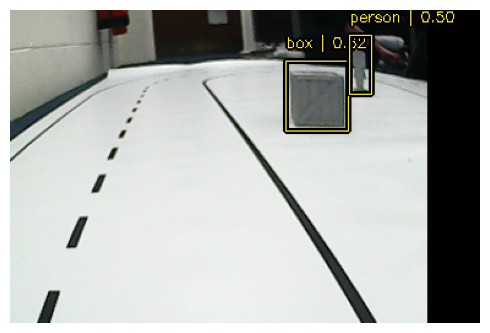

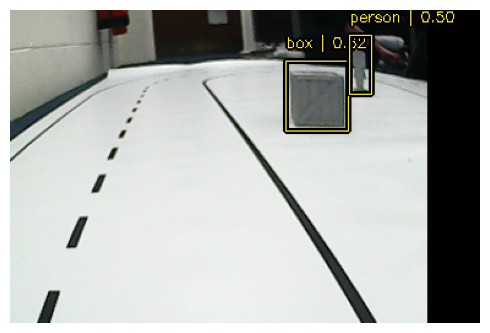

In [10]:
# Read and preprocess an image
image = tf.io.read_file("label_data/test/downloads_images/1709570998863_90_35.png")
image = tf.image.decode_png(image, channels=3)
image = tf.cast(image, tf.float32)
image = np.array(image)
image = validation_resizing([image])

# Set the input tensor to the image
interpreter.set_tensor(input_details[0]["index"], image)

# Run the inference
interpreter.invoke()

# Get the output tensor
y_pred = [
    interpreter.get_tensor(output_details[i]["index"])
    for i in range(len(output_details))
]

print(y_pred)
print(len(y_pred))
print(type(y_pred[0]))

# y_pred_print = y_pred.copy()
# y_pred_print["classes"] = [class_map[i] for i in y_pred["classes"].flatten() if i != -1]
# pprint(y_pred_print)
# """Format:
# {'boxes': [[x_left, y_top, width, height], ...],
#  'classes': [class_id, ...],
#  'confidence': [confidence, ...]
#  'num_detections': [int]}
# """

# keras_cv.visualization.plot_bounding_box_gallery(
#     image,
#     value_range=(0, 255),
#     rows=1,
#     cols=1,
#     y_pred=y_pred,
#     scale=5,
#     font_scale=0.4,
#     line_thickness=1,
#     bounding_box_format=BBOX_FORMAT,
#     class_mapping=class_map,
# )